In [1]:
import torch
from torch import nn
import torchvision
from preprocess import load_argumentation
from d2l import torch as d2l
import os

data_dir = '../dataset/imagenet-dog'
loss = nn.CrossEntropyLoss(reduction="none")
train_iter, train_valid_iter, valid_iter, test_iter, train_valid_ds, test_ds = load_argumentation(data_dir, 825, 256, 4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

训练样本为前9502个


In [2]:

def get_net(device):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet50(pretrained=True)
    # 定义一个新的输出网络，共有120个输出类别
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 120))
    finetune_net = finetune_net.to(device)
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

def evaluate_loss(data_iter, net, device):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(device), labels.to(device)
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return (l_sum / n).to('cpu')

In [3]:
def train_network(net, X, y, loss, optimizer, device):
    X, y = X.to(device), y.to(device)
    net.train()
    optimizer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    optimizer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [4]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, device, lr_period,
          lr_decay):
    net = net.to(device)
    optimizer = torch.optim.SGD((param for param in net.parameters()
                               if param.requires_grad), lr=lr,
                              momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_network(net, features, labels,
                                          loss, optimizer, device)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
        # print(f'Epoch{epoch}: train loss = {metric[0] / metric[2]:.3f}, train acc = {metric[1] / metric[2]:.3f}, val acc = {valid_acc}')
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(device)}')

Epoch19: train loss = 1.123, train acc = 0.714, val acc = 0.857421875
train loss 1.123, train acc 0.714, valid acc 0.857
254.7 examples/sec on cuda:0


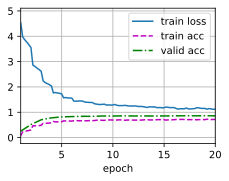

In [5]:
num_epochs, lr, wd = 20, 1e-5, 1e-5
lr_period, lr_decay, net = 2, 0.8, get_net(device)
train(net, train_iter, valid_iter, num_epochs, lr, wd, device, lr_period,
      lr_decay)

UnboundLocalError: local variable 'valid_acc' referenced before assignment

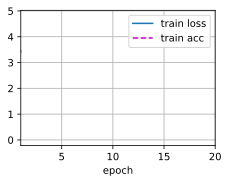

In [6]:
num_epochs, lr, wd = 20, 5e-5, 1e-5
lr_period, lr_decay, net = 2, 0.8, get_net(device)
train(net, train_valid_iter, None, num_epochs, lr, wd, device, lr_period,
      lr_decay)

preds = []
for data, label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(device)), dim=1)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(os.listdir(
    os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join(
            [str(num) for num in output]) + '\n')